In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder, ScanData,\
    init_map_model, BuildMapState
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_model_heatmap, plot_reconstructed_result
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, \
    OptimizePositionState
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import flax.linen as nn
import dataclasses
from nf_slam.space_hashing_mapping.map_model import MapModel
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
import optax
import functools
import jax
import jax_dataclasses as jdc
from dataclasses import dataclass
from nf_slam.space_hashing_mapping.jax_math import calculate_layer_embeddings
from nf_slam.space_hashing_mapping.mapping import transform_points, calculate_points
from flax.optim.adam import Adam
from flax.optim import OptimizerState

ROS is not sourced. To enable ROS features, please source it


In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
# datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

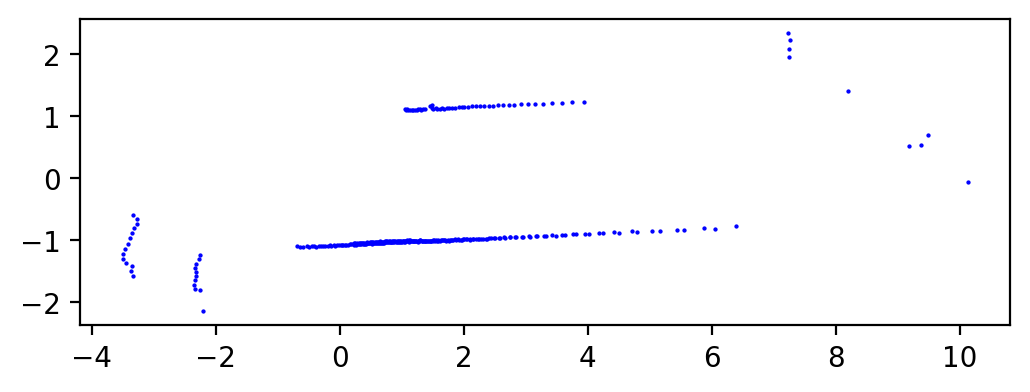

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[0:4:2], c="blue");

# Test map classification 

In [5]:
@jdc.pytree_dataclass
class LearningData:
    normal: jnp.array
        
        
@dataclass(unsafe_hash=True)
class MapModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    F: int
    L: int
    T: int
    max_log_resolution: float
    min_log_resolution: float

@dataclass(unsafe_hash=True)
class MapBuildingConfig:
    sampling_depth_delta: float
    sampling_depth_count: int
    classification_loss_weight: float
    point_loss_weight: float

In [6]:
def calculate_densities(points: jnp.array, map_model: MapModel, model: MLPModel):
    embedding = calculate_layer_embeddings(map_model.hashtable,
                                           points,
                                           map_model.resolutions,
                                           map_model.origins,
                                           map_model.hashtable.shape[1],
                                           map_model.hashtable.shape[0],
                                           map_model.rotations)
    embedding = jnp.transpose(embedding, (1, 0, 2)).reshape(embedding.shape[1], -1)
    return model.apply(map_model.variables, embedding)

@jax.jit
def transform_points(points, position):
    x = position[..., 0, None]
    y = position[..., 1, None]
    angle = position[..., 2, None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def mapping_classification_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                 learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    sampling_dephts = learning_data.normal * config.sampling_depth_delta  + scan_data.depths[..., None]
    points = calculate_points(sampling_dephts, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    labels = (jnp.sign(learning_data.normal.reshape(-1)) + 1) / 2.
    densities = calculate_densities(points, map_model, model)
    labels = jnp.where(labels < 0.5, labels, 0.8 * jax.nn.sigmoid(densities) + 0.2)
    return optax.sigmoid_binary_cross_entropy(densities, labels).mean()

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def mapping_point_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    sampling_dephts = scan_data.depths[..., None]
    points = calculate_points(sampling_dephts, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = calculate_densities(points, map_model, model)
    return (densities ** 2).mean()

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def mapping_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    return config.point_loss_weight * mapping_point_loss(map_model, position, scan_data,
                       learning_data, map_model_config, model, config) +\
           config.classification_loss_weight * mapping_classification_loss(map_model, position, scan_data,
                       learning_data, map_model_config, model, config) 

In [92]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    F=4,
    L=32,
    T=256,
    min_log_resolution=-2,
    max_log_resolution=1.,
)

map_building_config = MapBuildingConfig(
    sampling_depth_delta=3.,
    sampling_depth_count=20,
    point_loss_weight=1.,
    classification_loss_weight=1.
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=10e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
learning_index = 17
laser_data = laser_data_list[learning_index]
scan_data = ScanData.from_laser_data(laser_data)
map_model = init_map_model(mlp_model, map_model_config)
map_position = jnp.array(laser_data.odometry_position.as_vec())

variable_optimizer = Adam(**dataclasses.asdict(learning_config.variable_optimizer_config))
hashtable_optimizer = Adam(**dataclasses.asdict(learning_config.hashtable_optimizer_config))
        
loss_function = jax.jit(jax.value_and_grad(mapping_loss), static_argnums=[4, 5, 6])

state = BuildMapState(
            iteration=0,
            variable_state=variable_optimizer.init_state(map_model.variables),
            hashtable_state=hashtable_optimizer.init_state(map_model.hashtable)
)
for i in tqdm.tqdm(range(learning_config.iterations)):
    learning_data = LearningData(normal=jax.random.normal(
        jax.random.PRNGKey(i), (len(scan_data.depths), map_building_config.sampling_depth_count)))
    loss, grad = loss_function(map_model, map_position, scan_data, learning_data, map_model_config, mlp_model,
                            map_building_config)
    variables, variable_state = variable_optimizer.apply_gradient(
            variable_optimizer.hyper_params,
            map_model.variables,
            state.variable_state, grad.variables)
    hashtable, hashtable_state = hashtable_optimizer.apply_gradient(
            hashtable_optimizer.hyper_params,
            map_model.hashtable,
            state.hashtable_state, grad.hashtable)
    map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=map_model.resolutions,
                             origins=map_model.origins, rotations=map_model.rotations)
    state = BuildMapState(state.iteration + 1, variable_state, hashtable_state)


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.89it/s]


In [93]:
def plot_model_heatmap(map_model: MapModel, bounds, model, grid_shape=(200, 200), vmin=None, vmax=None):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]),
                                  jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilities = calculate_densities(grid, map_model, model)
    obstacle_probabilities = np.array(obstacle_probabilities).reshape(*grid_shape)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilities, cmap='RdBu', shading='auto',
                         vmin=vmin, vmax=vmax)
    plt.gca().set_aspect('equal')

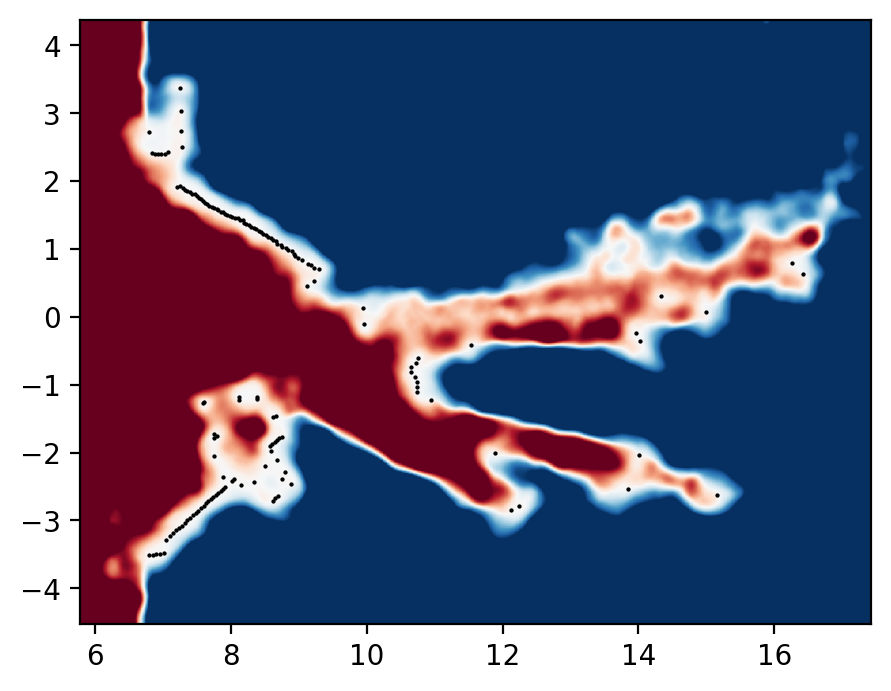

In [94]:
plt.figure(dpi=200)
value = 10
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), vmin=-value, vmax=value)
show_points(laser_data_list[learning_index:learning_index + 1], c="black");

In [114]:
@functools.partial(jax.jit, static_argnums=[1, ])
def huber(input_array, delta):
#     mask = jnp.abs(input_array) < delta
#     result = jnp.where(mask, input_array, jnp.sign(input_array) * (delta * (2 * jnp.abs(input_array) - delta)) ** 0.5)
    result = delta ** 2 * (jnp.sqrt((1 + (input_array / delta) ** 2)) - 1)
    result = jnp.sign(input_array) * jnp.sqrt(result)
    return result

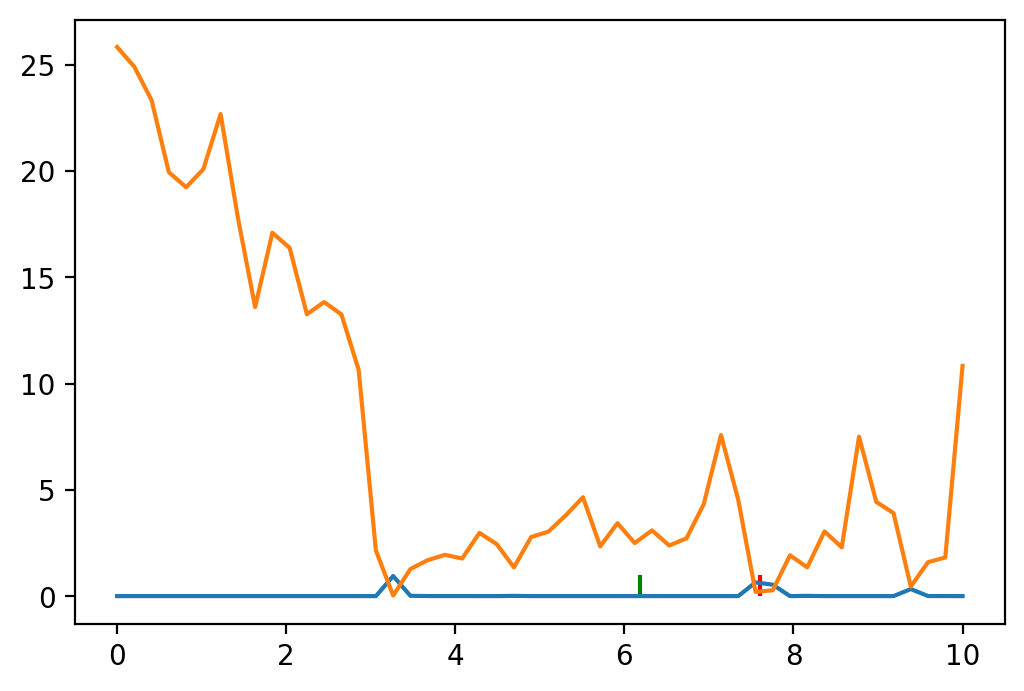

In [117]:
beam_index = 80
min_y = 0
max_y = 1
laser_data = laser_data_list[learning_index]
scan_data = ScanData.from_laser_data(laser_data)
sampling_dephts = jnp.linspace(0, 10, 50)
angle = scan_data.angles[beam_index]
x = sampling_dephts * jnp.cos(angle)
y = sampling_dephts * jnp.sin(angle)
angles = jnp.ones(sampling_dephts.shape) * angle
points = jnp.stack([x, y, angles], axis=-1)
points = transform_points(points, map_position).reshape(-1, 2)
densities = calculate_densities(points, map_model, mlp_model).reshape(-1)
plt.figure(dpi=200)
plt.plot(sampling_dephts, np.exp(-densities ** 2))
plt.plot(sampling_dephts, huber(densities, 1) ** 2)
# plt.plot(sampling_dephts, densities ** 2)
plt.vlines(scan_data.depths[beam_index], min_y, max_y, colors="red")
weights = np.exp(-densities ** 2)
mean_depth = np.sum(weights * sampling_dephts) / np.sum(weights)
plt.vlines(mean_depth, min_y, max_y, color="green")

In [68]:
@functools.partial(jax.jit, static_argnums=[4])
def reconstruct_depths(position: jnp.array, map_model: MapModel, bin_depths: jnp.array, 
                       scan_data: ScanData, mlp_model: MLPModel):
    sampling_depths = bin_depths[None, :]  + np.zeros((scan_data.depths.shape[0], 1))
    points = calculate_points(sampling_depths, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = calculate_densities(points, map_model, mlp_model).reshape(scan_data.depths.shape[0],
                                                                      bin_depths.shape[0])
    weights = jnp.exp(-densities ** 2)
    reconstructed_depths = jnp.sum(weights * sampling_depths, axis=1) / jnp.sum(weights, axis=1)
    return reconstructed_depths

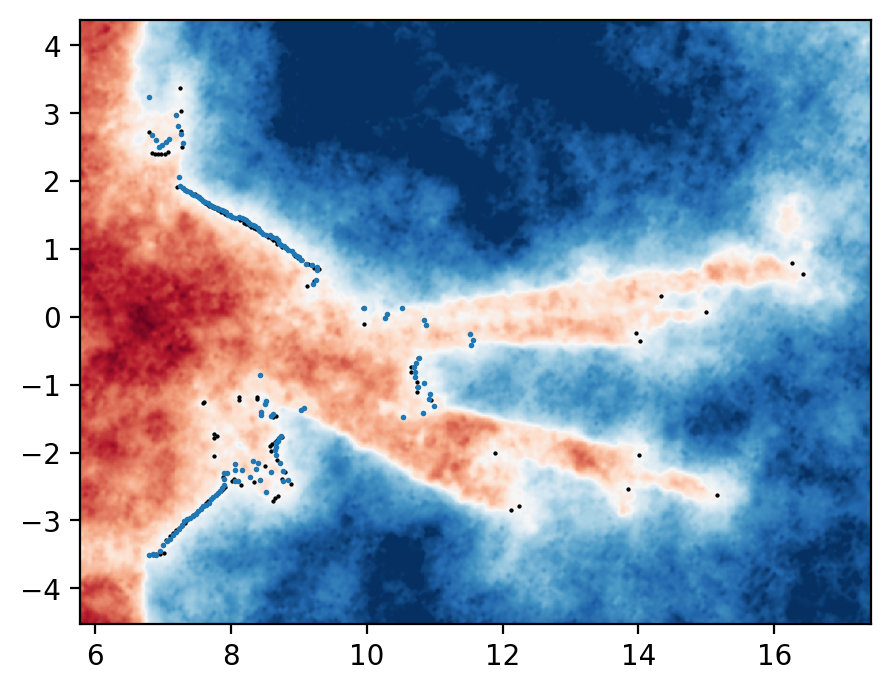

In [69]:
laser_data = laser_data_list[learning_index]
scan_data = ScanData.from_laser_data(laser_data)
bin_depths = jnp.linspace(1, 5, 100)
reconstructed_depths = reconstruct_depths(map_position, map_model, bin_depths, scan_data, mlp_model)

plt.figure(dpi=200)
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), vmin=-30, vmax=30)
show_points(laser_data_list[learning_index:learning_index + 1], c="black");
points = calculate_points(reconstructed_depths[..., None], scan_data)
points = transform_points(points, map_position).reshape(-1, 2)
plt.scatter(points[:, 0], points[:, 1], s=1)